In [1]:
import theme
theme.load_style()

# Introduction to Nonlinearity

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/80x15.png" /></a>

This lecture by Tim Fuller is licensed under the
<a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.  All code examples are also licensed under the [MIT license](http://opensource.org/licenses/MIT).

In [1]:
import numpy as np
import sympy as sp
%pylab inline
sp.init_printing("latex")

Populating the interactive namespace from numpy and matplotlib


Nonlinearity arises naturally in physical systems and can be modeled by finite elements in one (or more) of several ways.

# Types of Nonlinearity

They types of nonlinearity encountered in static analysis can be classified as either material nonlinearity or geometric nonlinearity.

- **Material Nonlinearity**: Nonlinear relationship between stress and strain
- **Geometric Nonlinearity**: Nonlinear relationship between strain and stretch

To illustrate, consider the case of nonlinear elasticity, 
$$
\sigma = f\left(\epsilon\right)
$$ 

where $\epsilon$ is a strain determined from the stretch $\lambda=L/L_0$

$$
\epsilon = g\left(\lambda\right)
$$

Here, $f$ and $g$ are nonlinear functions.  Combined, we get

$$
\sigma = f\left(g\left(\lambda\right)\right)
$$

Suppose laboratory experiments show

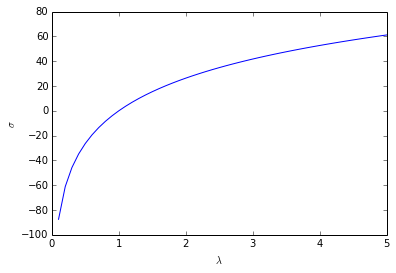

In [6]:
lam = np.linspace(.1, 5)
sig = 38 * np.log(lam)
plt.xlabel(r"$\lambda$")
plt.ylabel(r"$\sigma$")
plot(lam, sig);

There are many ways we can express the $f$ and $g$ functions:

$$\begin{align}
\sigma &= f\left(\epsilon\right) = 38 \epsilon \\
\epsilon &= g\left(\lambda\right) = \ln{\lambda}
\end{align}$$

or

$$\begin{align}
\sigma &= f\left(\epsilon\right) = 38 \ln{\left(\epsilon + 1\right)} \\
\epsilon &= g\left(\lambda\right) = \lambda - 1
\end{align}$$
 
or 

$$\begin{align}
\sigma &= f\left(\epsilon\right) = 19 \ln{\left(2\epsilon + 1\right)} \\
\epsilon &= g\left(\lambda\right) = \frac{1}{2}\left(\lambda^2 - 1\right)
\end{align}$$

etc.

When combined, all of these choices give

$$
\sigma = f\left(g\left(\lambda\right)\right) = 38 \ln{\lambda}
$$

Choice 1 has a linear stress-strain relationship but a nonlinear strain-stretch relationship.  This is called **geometric nonlinearity**.

Choice 2 has a nonlinear stress-strain relationship but a linear strain-stretch relationship.  This is called **material nonlinearity**.

Choice 3 has both material and geometric nonlinearity.

No matter the choice of where to put nonlinearity, the end result of stress as a function of stretch should be the same.  Thus, the terms
material nonlinearity and geometric nonlinearity are somewhat arbitrary.  They *do* indicate differences in the FEM implementation, but not differences in the final answer.

# Governing Equations of a 1D Elastic Solid

In solid mechanics, static equilibrium requires that

$$
\frac{d\sigma\left[u\right]}{dx} + b = 0
$$

where we have now that $\sigma\left[u\right]$ is a (not necessarily linear) function of the displacement $u$ and and $b$ is a force per unit volume.

The weak form is derived in the usual way

$$\begin{align}
&\int_{\Omega}\left(\frac{d\sigma\left[u\right]}{dx} + b\right)w\,dx = 0, \qquad \forall w \\
&\int_{\Omega}\left(\sigma\left[u\right]\frac{dw}{dx} - bw\right)\,dx - \sigma\left[u\right] w\Bigg|_{\partial \Omega} = 0
\end{align}
$$

Because stress is not necessarily linear in $u$, $u$ must be found iteratively.

## Finite Element Equations

The finite element solution procedure for the nonlinear problem follows nearly identical that of the linear problem, namely, the isplacement field is approximated by interpolating polynomials possessing the property of compact support (shape functions):

$$
u = \sum_{j=1}^n u_j N_j
$$

and the weighting functions as

$$
w = \sum_{i}^n w_i N_i
$$

The stress corresponding to a given displacement is found by computing the strain

$$
\epsilon = \frac{du}{dx} = \sum_{j=1}^{n}u_j \frac{dN_j}{dx}
$$

and then passing the strain to the material model $\sigma = \sigma\left[\epsilon\right]$

Upon substitution of the preceding equations in to the weak form we arrive at

$$
\int_{\Omega}\left(\sigma\left[\epsilon(u_j)\right]\frac{dN_i}{dx} - bN_i\right)\,dx - \sigma\left[\epsilon(u_j)\right] N_i\Bigg|_{\partial \Omega} = 0, \quad \forall x_i \text{ on } \partial_\sigma \Omega
$$
$$
u_i = u_i^*\left(x_i\right), \quad \forall x_i \text{ on }\partial_u\Omega
$$

This is a set of $n$ equations for the $n$ unknown nodal displacements $u_i$.  This set of equations is similar to those in the linear case, but because the the consititutive law relating stress and strain is not necessarily linear, it must be solved numerically.

### Newton-Raphson Iteration

One method of solving the finite element equations is by Newton-Raphson iteration whereby we
*linearize* the finite element equations about some guess for the $u_j$ and obtain successfully better approximations by iteration.  The linearization of $\sigma$ about $u_j$ is

$$
\sigma\left[u_k\right] \approx \sigma\left[u_k^0\right] + \frac{d\sigma}{du_k}du_k =  \sigma\left[u_k^0\right] + \frac{d\sigma}{d\epsilon}\frac{d\epsilon}{du_k}du_k
$$

recalling that 

$$
\epsilon = \sum_{k=1}^n u_k \frac{dN_k}{dx} \rightarrow 
\frac{d\epsilon}{du_j} = \sum_{k=1}^n \frac{du_k}{du_j} \frac{dN_k}{dx}
= \sum_{k=1}^n \delta_{kj} \frac{dN_k}{dx} = \frac{dN_j}{dx}
$$

we can write

$$
\int_{\Omega}\left(\frac{d\sigma}{d\epsilon}\frac{dN_i}{dx}\frac{dN_j}{dx}\,dx\right) du_j +
\int_{\Omega}\sigma\frac{dN_i}{dx}\, dx -
\int_{\Omega}bN_i\,dx - 
\sigma N_i\Bigg|_{\partial \Omega} = 0
$$

or

$$
K_{ij}du_{j} = F_{i} - R_{i}
$$

where
$$
K_{ij} =
\int_{\Omega}\frac{d\sigma}{d\epsilon}\frac{dN_i}{dx}\frac{dN_j}{dx}\,dx, \quad
R_{i} = \int_{\Omega}\sigma\frac{dN_i}{dx}\, dx, \quad
F_{i} = \int_{\Omega}bN_i\,dx + \sigma N_i\Bigg|_{\partial \Omega}
$$

This expression is nearly identical to the linear case with the addition of two terms:

- The strain dependent tangent material stiffness $\frac{d\sigma}{dx}$
- An element "residual" $R$

## Finite Element Algorithm

 **STEP 0** Initial guess for $u_j$ ($u_j=0$ is customary)  
 **STEP 1** Compute global $K_{ij}$, $R_i$, and $F_i$  
 **STEP 2** Enforce boundary conditions  
 **STEP 3** Solve $K_{ij}du_j = F_i - R_i$  
 **STEP 4** Set $u_j \leftarrow u_j + du_j$  
 **STEP 5** If $\lVert du_j\rVert>$ TOL: GO TO STEP 1  
 **STEP 6** Write output, postprocess, etc.

### Element Residual Calculation

Let us investigate what additional information we will need to compute the element residual.  The element residual is given by

$$
r_k^e = \int_{x_A}^{x_B}\sigma \frac{dN_k}{dx} dx
$$

Using Gauss-Legendre quadrature

$$
r_k^e = \int_{-1}^{1}\sigma \frac{1}{J} \frac{dN_k}{d\xi} Jd\xi
      = \sum_{l=1}^{n}\sigma\frac{dN_k\left(\xi_l\right)}{d\xi} w_l
$$

Computing the residual will require computing the stress at a Gauss point and, implicitly, the strain since $\sigma = f(\epsilon)$.  Recall tha the strain is given by

$$
\epsilon = \sum_{i=1}^{N} u_i \frac{dN_i}{dx} = \sum_{i=1}^{N} \frac{1}{J} u_i \frac{dN_i}{d\xi}
$$

#### Element Residual Update Algorithm

**data**
- Initial coordinates: $X$
- Current displacement: $u$

**external functions**
- Material constitutive model: $f$
 
**procedure**
- Step 1: Update nodal coordinates
  $$x_k=X_k+u_k$$

- Step 2: Initialize the element residual
  $$r_k^e=0$$

- Step 3: Perform Gauss integration  
  **for** $n$ from 1 to number of Gauss points **do**

  * Step a: Compute shape function derivative wrt to $\xi$ and the Jacobian
    $$\frac{dN_k}{d\xi} = \frac{dN_k\left(\xi_n\right)}{d\xi}$$
    $$J = J\left(x_k, \xi_n\right)$$
 
  * Step b: Compute the strain at $\xi_n$
    $$\epsilon = \sum_k \frac{1}{J} u_k \frac{dN_k\left(\xi_n\right)}{d\xi}$$
  
  * Step c: Compute the stress at $\xi_n$
    $$\sigma = f\left(\epsilon\right)$$
  
  * Step d: Update element residual    
    **for** $j$ from 1 to number of element nodes **do**
      $$r^e_j = r^e_j + \sigma\frac{dN_j}{d\xi} w_n$$
    **end for**
  
  **end for**

## Element Stiffness Calculation

The element stiffness calculation follows as before, except that instead of a constant element stiffness, the stiffness may change with deformation

### Element Stiffness Update Algorithm

**data**
- Initial coordinates: $X$
- Current displacement: $u$

**external functions**
- Material constitutive model: $f$

**procedure**  
* Step 1: Update nodal coordinates
  $$x_k=X_k+u_k$$

* Step 2: Initialize the element stiffness
  $$k_{ij}^e=0$$

* Step 3: Perform Gauss integration 
  **for** $n$ from 1 to number of Gauss points **do**

  - Step a: Compute shape function derivative wrt to $\xi$ and the Jacobian
    $$\frac{dN_k}{d\xi} = \frac{dN_k\left(\xi_n\right)}{d\xi}$$
    $$J = J\left(x_k, \xi_n\right)$$
 
  - Step b: Compute the strain at $\xi_n$
    $$\epsilon = \sum_k \frac{1}{J} u_k \frac{dN_k\left(\xi_n\right)}{d\xi}$$
  
  - Step c: Compute the element stiffness at $\xi_n$
    $$\frac{d\sigma}{d\epsilon} = f\left(\epsilon\right)$$
  
  - Step d: Update element stiffness    
    **for** $i$ from 1 to number of element nodes **do**   
      &nbsp;&nbsp;&nbsp;&nbsp;**for** $j$ from 1 to number of element nodes **do**
      $$k_{ij}^e = k_{ij}^e + 
               \frac{1}{J}\frac{d\sigma}{d\epsilon}\frac{dN_i}{d\xi}\frac{dN_i}{d\xi} w_n$$
      &nbsp;&nbsp;&nbsp;&nbsp;**end for**  
    **end for**
  
  **end for**

## Neo Hookean Material Model

An example of a nonlinear material model, widely used in the study of polymer-like materials subjected to moderate strains, is the single parameter Neo-Hookean material model whereby the stress is related to the stretch by

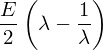

In [15]:
L, L0, lam, e, E = sp.symbols("L L0 lambda epsilon E")
s = E / 2 * (lam - 1 / lam)
s

where $E$ is Young's modulus.  In terms of engineering strain

$$
\epsilon = \frac{L - L_0}{L_0} = \lambda - 1 \rightarrow \lambda = \epsilon + 1
$$

the stress is

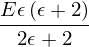

In [18]:
s = s.subs({lam: e + 1})
s.simplify()

The stiffness, $\frac{d\sigma}{d\epsilon}$ is given by

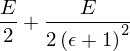

In [19]:
dsde = sp.diff(s, e)
dsde.simplify()

Let's make sure that the stiffness at $\epsilon=0$ is $E$

In [20]:
dsde.subs({e:0})

# Finite Element Implementation: Suggestions

- Implement a Newton solver using a linear elastic material model, verify it gives the same answer as the direct solver.

- Doing so will require calling an external material model whenever the stress and/or material stiffness are needed.  To reduce complications and repeated code, write a function like:

        def update_material_state(props, strain, mat_id=1):
            if mat_id == 1:
                # linear elastic
                E = props[0]
                stress = E * strain
                stiff = E
            elif mat_id == ...    
        return stress, stiff
        
  Different material models can then be implemented by giving them a mat_id, i.e., mat_id will now be a model input.  The FEModel constructor should also make sure that the props array is set up correctly for the material.
  
  When element stiffness and/or stress are needed, just call update_material_state as
  
         el_stress, el_stiff = update_material_id(props, strain, mat_id)
         
  Of course, you'll need to make sure that props, strain, and mat_id are correct.